In [110]:
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from numpy.linalg import inv, det, matrix_rank
import warnings 

In [111]:
# Limpa o console 
os.system('cls' if os.name == 'nt' else 'clear')
part1 = 'subject0'
part2 = 'subject'
part3 = ['.centerlight', '.glasses', '.happy', '.leftlight', '.noglasses', '.normal', '.rightlight', '.sad', '.sleepy', '.surprised', '.wink']

Nind = 15   # Quantidade de individuos
Nexp = len(part3)  # Quantidade de expressoes

X = []  # Lista para acumular imagens vetorizadas
Y = []  # Lista para acumular o rotulo do individuo


In [112]:
for i in range(1, Nind + 1):  # Indice para os individuos
    individuo = i

    for j in range(Nexp):   # Indice para expressoes
        if i < 10:
            nome = f"{part1}{i}{part3[j]}"    # Monta o nome do arquivo de imagem
        else:
            nome = f"{part2}{i}{part3[j]}"

        try:
            Img = Image.open(nome).convert('L')  # le imagem e converte para escala de cinza
        except FileNotFoundError:
            print(f"Aviso: Imagem '{nome}' não encontrada. Pulando.")
            continue
        except Exception as e:
            print(f"Erro ao carregar a imagem '{nome}': {e}. Pulando.")
            continue

        # Redimensiona imagem
        Ar = Img.resize((20, 20))

        An = np.array(Ar) # An = Ar.copy() # An=imnoise(Ar,'gaussian',0,0.005);  # adiciona ruido (requer implementação de ruído)

        A = An.astype(np.float64) / 255.0  # converte para double precision (normaliza para 0-1)
 
        a = A.flatten()  # Etapa de vetorizacao: Empilhamento das colunas

        ROT = i   # Rotulo = indice do individuo

        X.append(a) # Coloca cada imagem vetorizada como linha da matriz X (será transposta depois)
        Y.append(ROT) # Coloca o rotulo de cada vetor

X = np.array(X).T  # Transpõe para ter cada imagem vetorizada como coluna (como no MATLAB)
Y = np.array(Y)

Z = np.vstack((X, Y))  # Formato 01 vetor de atributos por coluna: DIM(Z) = (p+1)xN
Z = Z.T     # Formato 01 vetor de atributos por linha: DIM(Z) = Nx(p+1)

#  Salva os dados em um arquivo .dat
np.savetxt('recfaces.dat', Z, fmt='%.6f') # fmt='%.6f' para manter a precisão float

print("Imagens carregadas e vetorizadas. Dimensão de X:", X.shape)
print("Dimensão de Y:", Y.shape)


Imagens carregadas e vetorizadas. Dimensão de X: (400, 165)
Dimensão de Y: (165,)


# Definição das funções dos classificadores

## Classificador Quadrático

In [113]:
def quadratico(D, Nr, Ptrain):

    # Carrega os dados do arquivo .dat
    X_data = D[:, :-1]
    y_labels = D[:, -1]

    # 
    classes = np.unique(y_labels)
    num_classes = len(classes)
    p = X_data.shape[1] # Número de atributos
 
    TX_OK = np.zeros(Nr)
    X_last_run = None
    m_last_run = None
    S_last_run = None
    posto_last_run = None

    # Contador para matrizes de covariância singulares
    sing_matrices = 0

    # Realiza o treinamento e teste do classificador quadrático em Nr iterações
    for r in range(Nr):
        # Divide os dados em conjuntos de treinamento e teste de acordo com Ptrain
        X_train, X_test, y_train, y_test = train_test_split(
            X_data, y_labels, test_size=(100 - Ptrain) / 100.0, stratify=y_labels, random_state=r
        )
        
        centroids = {}
        cov_data = {}
        cov_posts = {}
        
        # Estima os centróides e matrizes de covariância para cada classe
        for c in classes:
            X_train_c = X_train[y_train == c]
            Ni = X_train_c.shape[0]

            centroids[c] = np.mean(X_train_c, axis=0)
            Ci = np.cov(X_train_c, rowvar=False)
            
            post_Ci = matrix_rank(Ci)
            cov_posts[c] = post_Ci

            try:
                inv_Ci = inv(Ci)
                det_Ci = det(Ci)
                cov_data[c] = {
                    'matrix': Ci,
                    'inv': inv_Ci,
                    'det': det_Ci
                }
            except np.linalg.LinAlgError:
                warnings.warn(f"Matriz de covariância para a classe {c} é singular. O classificador falhará para esta classe.")
                sing_matrices += 1
                cov_data[c] = None

        # Armazena os resultados da última iteração
        if r == Nr - 1:
            X_last_run = X_train
            m_last_run = centroids
            S_last_run = {c: data['matrix'] for c, data in cov_data.items() if data is not None}
            posto_last_run = cov_posts

        # Calcula a taxa de acerto para o conjunto de teste
        correct_predictions = 0
        for i, x_test_sample in enumerate(X_test):
            true_label = y_test[i]
            
            discriminant_values = {}
            for c in classes:
                if c not in centroids or centroids[c] is None or cov_data[c] is None:
                    discriminant_values[c] = np.inf
                    continue
                
                m_i = centroids[c]
                inv_Ci = cov_data[c]['inv']
                det_Ci = cov_data[c]['det']
                prob_prior_c = len(y_train[y_train == c]) / len(y_train)

                diff = x_test_sample - m_i
                
                if det_Ci <= 0:
                    warnings.warn(f"Determinante para classe {c} não-positivo. Tratando log como -inf.")
                    ln_det_Ci = -np.inf
                else:
                    ln_det_Ci = np.log(det_Ci)

                ln_f_omega_i = np.log(prob_prior_c) if prob_prior_c > 0 else -np.inf

                try:
                    # Distância quadrática 
                    Qi_x = diff.T @ inv_Ci @ diff
                    # Função discriminante do classificador quadrático
                    gi_star_x = Qi_x + ln_det_Ci - 2 * ln_f_omega_i
                    discriminant_values[c] = gi_star_x
                except ValueError:
                    discriminant_values[c] = np.inf
            
            if not discriminant_values or all(v == np.inf for v in discriminant_values.values()):
                predicted_label = -1 
            else:
                predicted_label = min(discriminant_values, key=discriminant_values.get)
            
            if predicted_label == true_label:
                correct_predictions += 1

        TX_OK[r] = (correct_predictions / len(X_test)) * 100 if len(X_test) > 0 else 0

    # Calcula estatísticas da taxa de acerto
    stats_df = pd.Series(TX_OK).describe()
    STATS = {
        'Média': stats_df['mean'],
        'Mínimo': stats_df['min'],
        'Máximo': stats_df['max'],
        'Mediana': stats_df['50%'],
        'Desvio Padrão': stats_df['std']
    }

    return STATS, TX_OK, X_last_run, m_last_run, S_last_run, posto_last_run, sing_matrices

## Variante 1 do Classificador Quadrático

In [114]:
def variante1(D, Nr, Ptrain, lambda_reg=0.1):

    # Carrega os dados do arquivo .dat
    X_data = D[:, :-1]
    y_labels = D[:, -1]

    classes = np.unique(y_labels)
    num_classes = len(classes)
    p = X_data.shape[1]

    TX_OK = np.zeros(Nr)
    X_last_run = None
    m_last_run = None
    S_last_run = None
    posto_last_run = None

    # Contador para matrizes de covariância singulares
    sing_matrices = 0

    # Realiza o treinamento e teste do classificador quadrático variante 1 em Nr iterações
    for r in range(Nr):
        # Divide os dados em conjuntos de treinamento e teste de acordo com Ptrain
        X_train, X_test, y_train, y_test = train_test_split(
            X_data, y_labels, test_size=(100 - Ptrain) / 100.0, stratify=y_labels, random_state=r
        )
        
        centroids = {}
        cov_data_reg = {}
        cov_posts = {}

        # Estima os centróides e matrizes de covariância regularizadas para cada classe
        for c in classes:
            X_train_c = X_train[y_train == c]
            Ni = X_train_c.shape[0]

            centroids[c] = np.mean(X_train_c, axis=0)
            Ci = np.cov(X_train_c, rowvar=False)

            # Aplicando regularização de Tikhonov
            Ci_reg = Ci + lambda_reg * np.eye(p)
            
            cov_posts[c] = matrix_rank(Ci_reg)

            try:
                cov_data_reg[c] = {
                    'matrix': Ci_reg,
                    'inv': inv(Ci_reg),
                    'det': det(Ci_reg)
                }
            except np.linalg.LinAlgError:
                warnings.warn(f"Matriz de covariância regularizada para classe {c} é singular. Aumente lambda_reg.")
                sing_matrices += 1
                cov_data_reg[c] = None

        # Armazena os resultados da última iteração
        if r == Nr - 1:
            X_last_run = X_train
            m_last_run = centroids
            S_last_run = {c: data['matrix'] for c, data in cov_data_reg.items() if data is not None}
            posto_last_run = cov_posts

        # Calcula a taxa de acerto para o conjunto de teste
        correct_predictions = 0
        for i, x_test_sample in enumerate(X_test):
            true_label = y_test[i]
            discriminant_values = {}

            for c in classes:
                if c not in centroids or cov_data_reg[c] is None:
                    discriminant_values[c] = np.inf
                    continue

                m_i = centroids[c]
                inv_Ci_reg = cov_data_reg[c]['inv']
                det_Ci_reg = cov_data_reg[c]['det']
                prob_prior_c = len(y_train[y_train == c]) / len(y_train)

                diff = x_test_sample - m_i
                
                ln_det_Ci_reg = np.log(det_Ci_reg) if det_Ci_reg > 0 else -np.inf
                ln_f_omega_i = np.log(prob_prior_c) if prob_prior_c > 0 else -np.inf

                try:
                    # Distância quadrática com a matriz regularizada
                    Qi_lambda_x = diff.T @ inv_Ci_reg @ diff
                    # Função discriminante da Variante 1
                    gi_star_x = Qi_lambda_x + ln_det_Ci_reg - 2 * ln_f_omega_i
                    discriminant_values[c] = gi_star_x
                except ValueError:
                    discriminant_values[c] = np.inf
            
            if not discriminant_values or all(v == np.inf for v in discriminant_values.values()):
                predicted_label = -1
            else:
                predicted_label = min(discriminant_values, key=discriminant_values.get)
            
            if predicted_label == true_label:
                correct_predictions += 1

        TX_OK[r] = (correct_predictions / len(X_test)) * 100 if len(X_test) > 0 else 0

    # Calcula estatísticas da taxa de acerto
    stats_df = pd.Series(TX_OK).describe()
    STATS = {
        'Média': stats_df['mean'],
        'Mínimo': stats_df['min'],
        'Máximo': stats_df['max'],
        'Mediana': stats_df['50%'],
        'Desvio Padrão': stats_df['std']
    }

    return STATS, TX_OK, X_last_run, m_last_run, S_last_run, posto_last_run, sing_matrices

## Variante 2 do Classificador Quadrático

In [115]:

def variante2(D, Nr, Ptrain):
    # Carrega os dados do arquivo .dat
    X_data = D[:, :-1]
    y_labels = D[:, -1]
    
    classes = np.unique(y_labels)
    p = X_data.shape[1] # Número de atributos

    TX_OK = np.zeros(Nr)
    
    X_last_run = None
    m_last_run = None
    S_last_run = None
    posto_last_run = None

    # Contador para matrizes de covariância singulares
    sing_matrices = 0

    # Realiza o treinamento e teste do classificador quadrático variante 2 em Nr iterações
    for r in range(Nr):
        X_train, X_test, y_train, y_test = train_test_split(
            X_data, y_labels, test_size=(100 - Ptrain) / 100.0, stratify=y_labels, random_state=r
        )

        centroids = {}
        pooled_cov_matrix = np.zeros((p, p))
        total_samples_train = len(X_train)
        
        # Estima os centroides e calcular a matriz de covariância agregada (pooled)
        for c in classes:
            X_train_c = X_train[y_train == c]
            Ni = X_train_c.shape[0]

            centroids[c] = np.mean(X_train_c, axis=0)
            Ci = np.cov(X_train_c, rowvar=False)
            
            # Adicionar a contribuição ponderada da classe à matriz agregada
            if total_samples_train > 0:
                pooled_cov_matrix += (Ni / total_samples_train) * Ci
        
        # Armazena os resultados da última iteração
        if r == Nr - 1:
            X_last_run = X_train
            m_last_run = centroids
            S_last_run = pooled_cov_matrix
            posto_last_run = matrix_rank(pooled_cov_matrix)

        try:
            inv_Cpool = inv(pooled_cov_matrix)
            det_Cpool = det(pooled_cov_matrix)
        except np.linalg.LinAlgError:
            warnings.warn("Matriz de covariância agregada é singular. O classificador falhará nesta repetição.")
            sing_matrices += 1
            TX_OK[r] = 0
            continue

        correct_predictions = 0
        for i, x_test_sample in enumerate(X_test):
            true_label = y_test[i]
            discriminant_values = {}

            for c in classes:
                if c not in centroids:
                    discriminant_values[c] = np.inf
                    continue

                m_i = centroids[c]
                diff = x_test_sample - m_i
                
                # Distância quadrática usando a matriz agregada
                Q_pool_i_x = diff.T @ inv_Cpool @ diff
                
                prob_prior_c = len(y_train[y_train == c]) / len(y_train)
                ln_f_omega_i = np.log(prob_prior_c) if prob_prior_c > 0 else -np.inf

                # Função discriminante da Variante 2 
                gi_star_x = Q_pool_i_x - 2 * ln_f_omega_i
                discriminant_values[c] = gi_star_x

            if not discriminant_values or all(v == np.inf for v in discriminant_values.values()):
                predicted_label = -1
            else:
                predicted_label = min(discriminant_values, key=discriminant_values.get)
            
            if predicted_label == true_label:
                correct_predictions += 1

        TX_OK[r] = (correct_predictions / len(X_test)) * 100 if len(X_test) > 0 else 0

    # Calcula estatísticas da taxa de acerto
    stats_series = pd.Series(TX_OK).describe()
    STATS = {
        'Média': stats_series['mean'],
        'Mínimo': stats_series['min'],
        'Máximo': stats_series['max'],
        'Mediana': stats_series['50%'],
        'Desvio Padrão': stats_series['std']
    }

    return STATS, TX_OK, X_last_run, m_last_run, S_last_run, posto_last_run, sing_matrices

## Variante 3 do Classificador Quadrático

In [116]:
def variante3(D, Nr, Ptrain, lambda_friedman=0.5):

    # Carrega os dados do arquivo .dat
    X_data = D[:, :-1]
    y_labels = D[:, -1]
    
    classes = np.unique(y_labels)
    p = X_data.shape[1]

    TX_OK = np.zeros(Nr)
    
    X_last_run = None
    m_last_run = None
    S_last_run = None
    posto_last_run = None

    # Contador para matrizes de covariância singulares
    sing_matrices = 0

    # Realiza o treinamento e teste do classificador quadrático variante 3 em Nr iterações
    for r in range(Nr):
        X_train, X_test, y_train, y_test = train_test_split(
            X_data, y_labels, test_size=(100 - Ptrain) / 100.0, stratify=y_labels, random_state=r
        )

        centroids = {}
        class_cov_matrices = {}
        N_train_per_class = {}
        
        # Estima os centroides e matrizes de covariância para cada classe
        for c in classes:
            X_train_c = X_train[y_train == c]
            Ni = X_train_c.shape[0]
            N_train_per_class[c] = Ni

            centroids[c] = np.mean(X_train_c, axis=0)
            class_cov_matrices[c] = np.cov(X_train_c, rowvar=False)
        
        # Calcula a matriz de covariância agregada (pooled)
        pooled_cov_matrix_raw = np.zeros((p, p))
        total_samples_train = len(X_train)
        
        for c in classes:
            if c in class_cov_matrices and total_samples_train > 0:
                pooled_cov_matrix_raw += (N_train_per_class[c] / total_samples_train) * class_cov_matrices[c]
        
        class_cov_matrices_friedman = {}
        cov_posts_friedman = {}

        for c in classes:
            if c not in centroids:
                class_cov_matrices_friedman[c] = None
                cov_posts_friedman[c] = 0
                continue
            
            Ci = class_cov_matrices[c]

            # Regularização de Friedman
            Ci_lambda = (1 - lambda_friedman) * Ci + lambda_friedman * pooled_cov_matrix_raw
            
            # Calcula o posto da matriz de Friedman
            cov_posts_friedman[c] = matrix_rank(Ci_lambda)

            try:
                class_cov_matrices_friedman[c] = {
                    'matrix': Ci_lambda,
                    'inv': inv(Ci_lambda),
                    'det': det(Ci_lambda)
                }
            except np.linalg.LinAlgError:
                warnings.warn(f"Matriz de covariância de Friedman para classe {c} é singular. Ajuste lambda_friedman.")
                sing_matrices += 1
                class_cov_matrices_friedman[c] = None

        # Armazena os resultados da última iteração
        if r == Nr - 1:
            X_last_run = X_train
            m_last_run = centroids
            S_last_run = {c: data['matrix'] for c, data in class_cov_matrices_friedman.items() if data is not None}
            posto_last_run = cov_posts_friedman

        # Calcula a taxa de acerto para o conjunto de teste
        correct_predictions = 0
        for i, x_test_sample in enumerate(X_test):
            true_label = y_test[i]
            discriminant_values = {}

            for c in classes:
                if c not in centroids or class_cov_matrices_friedman[c] is None:
                    discriminant_values[c] = np.inf
                    continue

                m_i = centroids[c]
                inv_Ci_lambda = class_cov_matrices_friedman[c]['inv']
                det_Ci_lambda = class_cov_matrices_friedman[c]['det']
                prob_prior_c = len(y_train[y_train == c]) / len(y_train)

                diff = x_test_sample - m_i
                
                # Tratamento para determinantes não-positivos
                ln_det_Ci_lambda = np.log(det_Ci_lambda) if det_Ci_lambda > 0 else -np.inf
                ln_f_omega_i = np.log(prob_prior_c) if prob_prior_c > 0 else -np.inf

                try:
                    # Distância quadrática com a matriz de Friedman
                    Qi_lambda_x = diff.T @ inv_Ci_lambda @ diff
                    # Função discriminante da Variante 3
                    gi_star_x = Qi_lambda_x + ln_det_Ci_lambda - 2 * ln_f_omega_i
                    discriminant_values[c] = gi_star_x
                except ValueError:
                    discriminant_values[c] = np.inf
            
            if not discriminant_values or all(v == np.inf for v in discriminant_values.values()):
                predicted_label = -1
            else:
                predicted_label = min(discriminant_values, key=discriminant_values.get)
            
            if predicted_label == true_label:
                correct_predictions += 1

        TX_OK[r] = (correct_predictions / len(X_test)) * 100 if len(X_test) > 0 else 0

    # Calcula estatísticas da taxa de acerto
    stats_series = pd.Series(TX_OK).describe()
    STATS = {
        'Média': stats_series['mean'],
        'Mínimo': stats_series['min'],
        'Máximo': stats_series['max'],
        'Mediana': stats_series['50%'],
        'Desvio Padrão': stats_series['std']
    }

    return STATS, TX_OK, X_last_run, m_last_run, S_last_run, posto_last_run, sing_matrices

        


## Variante 4 do Classificador Quadrático

In [117]:
def variante4(D, Nr, Ptrain):

    # Carrega os dados do arquivo .dat
    X_data = D[:, :-1]
    y_labels = D[:, -1]

    classes = np.unique(y_labels)
    num_classes = len(classes)

    TX_OK = np.zeros(Nr)
    
    X_last_run = None
    m_last_run = None
    S_last_run = None
    posto_last_run = None

    # Contador para matrizes de covariância singulares
    sing_matrices = 0

    # Realiza o treinamento e teste do classificador quadrático variante 4 em Nr iterações
    for r in range(Nr):
        X_train, X_test, y_train, y_test = train_test_split(
            X_data, y_labels, test_size=(100 - Ptrain) / 100.0, stratify=y_labels, random_state=r
        )

        centroids = {}
        cov_data_diag = {}
        cov_posts_diag = {}

        # Estima os centróides e matrizes de covariância diagonal para cada classe
        for c in classes:
            X_train_c = X_train[y_train == c]
            Ni = X_train_c.shape[0]

            centroids[c] = np.mean(X_train_c, axis=0)
            Ci = np.cov(X_train_c, rowvar=False)

            # Cria a matriz de covariância diagonal
            Ci_diag = np.diag(np.diag(Ci))
            
            # Calcula o posto da matriz diagonal
            cov_posts_diag[c] = matrix_rank(Ci_diag)

            try:
                cov_data_diag[c] = {
                    'matrix': Ci_diag,
                    'inv': inv(Ci_diag),
                    'det': det(Ci_diag)
                }
            except np.linalg.LinAlgError:
                warnings.warn(f"Matriz de covariância diagonal para classe {c} é singular. O classificador falhará.")
                sing_matrices += 1
                cov_data_diag[c] = None

        # Armazena os resultados da última iteração
        if r == Nr - 1:
            X_last_run = X_train
            m_last_run = centroids
            S_last_run = {c: data['matrix'] for c, data in cov_data_diag.items() if data is not None}
            posto_last_run = cov_posts_diag

        # Calcula a taxa de acerto para o conjunto de teste
        correct_predictions = 0
        for i, x_test_sample in enumerate(X_test):
            true_label = y_test[i]
            discriminant_values = {}

            for c in classes:
                if c not in centroids or cov_data_diag[c] is None:
                    discriminant_values[c] = np.inf
                    continue

                m_i = centroids[c]
                inv_Ci_diag = cov_data_diag[c]['inv']
                det_Ci_diag = cov_data_diag[c]['det']
                prob_prior_c = len(y_train[y_train == c]) / len(y_train)

                diff = x_test_sample - m_i
                
                ln_det_Ci_diag = np.log(det_Ci_diag) if det_Ci_diag > 0 else -np.inf
                ln_f_omega_i = np.log(prob_prior_c) if prob_prior_c > 0 else -np.inf

                try:
                    # Distância quadrática usando a matriz diagonal
                    Q_diag_i_x = diff.T @ inv_Ci_diag @ diff
                    # Função discriminante do classificador quadrático variante 4
                    gi_star_x = Q_diag_i_x + ln_det_Ci_diag - 2 * ln_f_omega_i
                    discriminant_values[c] = gi_star_x
                except ValueError:
                    discriminant_values[c] = np.inf
            
            if not discriminant_values or all(v == np.inf for v in discriminant_values.values()):
                predicted_label = -1
            else:
                predicted_label = min(discriminant_values, key=discriminant_values.get)
            
            if predicted_label == true_label:
                correct_predictions += 1

        TX_OK[r] = (correct_predictions / len(X_test)) * 100 if len(X_test) > 0 else 0

    # Calcula estatísticas da taxa de acerto
    stats_series = pd.Series(TX_OK).describe()
    STATS = {
        'Média': stats_series['mean'],
        'Mínimo': stats_series['min'],
        'Máximo': stats_series['max'],
        'Mediana': stats_series['50%'],
        'Desvio Padrão': stats_series['std']
    }

    return STATS, TX_OK, X_last_run, m_last_run, S_last_run, posto_last_run, sing_matrices


## Classificador Vizinho mais próximo

In [118]:
def NN(D, Nr, Ptrain):
    # Carrega os dados do arquivo .dat
    X_data = D[:, :-1]
    y_labels = D[:, -1]

    classes = np.unique(y_labels)

    TX_OK = np.zeros(Nr)
    
    X_last_run = None
    m_last_run = None
    S_last_run = None
    posto_last_run = None

    # Realiza o treinamento e teste do classificador 1-NN em Nr iterações
    for r in range(Nr):
        X_train, X_test, y_train, y_test = train_test_split(
            X_data, y_labels, test_size=(100 - Ptrain) / 100.0, stratify=y_labels, random_state=r
        )
        
        # O treinamento do 1-NN consiste apenas em armazenar os dados de treino
        if r == Nr - 1:
            X_last_run = X_train
        
        # Calcula a taxa de acerto para o conjunto de teste
        correct_predictions = 0
        for i, x_test_sample in enumerate(X_test):
            true_label = y_test[i]
            
            # Calcula a distância euclidiana ao quadrado para todos os vetores de treino
            diffs = X_train - x_test_sample
            dists = np.sum(diffs**2, axis=1)
            
            # Encontra o índice do vizinho mais próximo
            nearest_neighbor_index = np.argmin(dists)
            
            predicted_label = y_train[nearest_neighbor_index]
            
            if predicted_label == true_label:
                correct_predictions += 1
        
        TX_OK[r] = (correct_predictions / len(X_test)) * 100 if len(X_test) > 0 else 0

    # Calcula estatísticas da taxa de acerto
    stats_series = pd.Series(TX_OK).describe()
    STATS = {
        'Média': stats_series['mean'],
        'Mínimo': stats_series['min'],
        'Máximo': stats_series['max'],
        'Mediana': stats_series['50%'],
        'Desvio Padrão': stats_series['std']
    }

    return STATS, TX_OK, X_last_run, m_last_run, S_last_run, posto_last_run

## Classificador Distância mínima do centróide

In [119]:
def MDC(D, Nr, Ptrain):
    # Carrega os dados do arquivo .dat
    X_data = D[:, :-1]
    y_labels = D[:, -1]

    classes = np.unique(y_labels)

    TX_OK = np.zeros(Nr)
    
    X_last_run = None
    m_last_run = None
    S_last_run = None
    posto_last_run = None

    # Realiza o treinamento e teste do classificador MDC em Nr iterações
    for r in range(Nr):
        X_train, X_test, y_train, y_test = train_test_split(
            X_data, y_labels, test_size=(100 - Ptrain) / 100.0, stratify=y_labels, random_state=r
        )
        
        centroids = {}
        for c in classes:
            X_train_c = X_train[y_train == c]
            centroids[c] = np.mean(X_train_c, axis=0)

        # Treinamento e parâmetros da última rodada
        if r == Nr - 1:
            X_last_run = X_train
            m_last_run = centroids
        
        # Calcula a taxa de acerto para o conjunto de teste
        correct_predictions = 0
        for i, x_test_sample in enumerate(X_test):
            true_label = y_test[i]
            
            dists = {}
            for c in classes:
                if c in centroids:
                    # Distância euclidiana 
                    dist = np.linalg.norm(x_test_sample - centroids[c])
                    dists[c] = dist
                else:
                    dists[c] = np.inf
            
            if not dists or all(v == np.inf for v in dists.values()):
                predicted_label = -1
            else:
                predicted_label = min(dists, key=dists.get)
            
            if predicted_label == true_label:
                correct_predictions += 1
        
        TX_OK[r] = (correct_predictions / len(X_test)) * 100 if len(X_test) > 0 else 0

    # Calcula estatísticas da taxa de acerto
    stats_series = pd.Series(TX_OK).describe()
    STATS = {
        'Média': stats_series['mean'],
        'Mínimo': stats_series['min'],
        'Máximo': stats_series['max'],
        'Mediana': stats_series['50%'],
        'Desvio Padrão': stats_series['std']
    }

    return STATS, TX_OK, X_last_run, m_last_run, S_last_run, posto_last_run

## Classificador de máxima correlação

In [120]:
def MaxCorr(D, Nr, Ptrain):
    # Carrega os dados do arquivo .dat
    X_data = D[:, :-1]
    y_labels = D[:, -1]

    classes = np.unique(y_labels)
    
    TX_OK = np.zeros(Nr)
    
    X_last_run = None
    m_last_run = None
    S_last_run = None
    posto_last_run = None

    # Realiza o treinamento e teste do classificador de máxima correlação em Nr iterações
    for r in range(Nr):
        X_train, X_test, y_train, y_test = train_test_split(
            X_data, y_labels, test_size=(100 - Ptrain) / 100.0, stratify=y_labels, random_state=r
        )
        
        centroids = {}
        for c in classes:
            X_train_c = X_train[y_train == c]
            centroids[c] = np.mean(X_train_c, axis=0)
            
        # Normaliza os centroides para norma unitária
        normalized_centroids = {}
        for c, centroid in centroids.items():
            norm_centroid = np.linalg.norm(centroid)
            if norm_centroid > 0:
                normalized_centroids[c] = centroid / norm_centroid
            else:
                normalized_centroids[c] = centroid # Evita divisão por zero
        
        # Treinamento e parâmetros da última rodada
        if r == Nr - 1:
            X_last_run = X_train
            m_last_run = normalized_centroids
            
        # Calcula a taxa de acerto para o conjunto de teste
        correct_predictions = 0
        for i, x_test_sample in enumerate(X_test):
            true_label = y_test[i]
            
            # Normaliza o vetor de teste
            norm_test_sample = np.linalg.norm(x_test_sample)
            if norm_test_sample > 0:
                normalized_test_sample = x_test_sample / norm_test_sample
            else:
                normalized_test_sample = x_test_sample

            similarities = {}
            for c in classes:
                if c in normalized_centroids:
                    # Calcula o produto escalar (correlação)
                    sim = np.dot(normalized_test_sample, normalized_centroids[c])
                    similarities[c] = sim
                else:
                    similarities[c] = -np.inf # Similaridade mínima
            
            if not similarities or all(v == -np.inf for v in similarities.values()):
                predicted_label = -1
            else:
                predicted_label = max(similarities, key=similarities.get)
            
            if predicted_label == true_label:
                correct_predictions += 1
        
        TX_OK[r] = (correct_predictions / len(X_test)) * 100 if len(X_test) > 0 else 0

    # Calcula estatísticas da taxa de acerto
    stats_series = pd.Series(TX_OK).describe()
    STATS = {
        'Média': stats_series['mean'],
        'Mínimo': stats_series['min'],
        'Máximo': stats_series['max'],
        'Mediana': stats_series['50%'],
        'Desvio Padrão': stats_series['std']
    }

    return STATS, TX_OK, X_last_run, m_last_run, S_last_run, posto_last_run

# Carregamento dos dados e execução dos classificadores sem PCA 

In [121]:
# Carrega os dados
try:
    D = np.loadtxt('recfaces.dat')
except FileNotFoundError:
    print("Erro: 'recfaces.dat' não encontrado. Por favor, execute 'face_preprocessing_column.py' primeiro.")
    exit()

Nr = 50  # No. de repeticoes
Ptrain = 80  # Porcentagem de treinamento

# Executa os classificadores
start_time = time.time()
STATS_0, TX_OK0, X0, m0, S0, posto0, sing0 = quadratico(D, Nr, Ptrain)
Tempo0 = time.time() - start_time

start_time = time.time()
STATS_1, TX_OK1, X1, m1, S1, posto1, sing1 = variante1(D, Nr, Ptrain, 0.01)
Tempo1 = time.time() - start_time

start_time = time.time()
STATS_2, TX_OK2, X2, m2, S2, posto2, sing2 = variante2(D, Nr, Ptrain)
Tempo2 = time.time() - start_time

start_time = time.time()
STATS_3, TX_OK3, X3, m3, S3, posto3, sing3 = variante3(D, Nr, Ptrain, 0.5)
Tempo3 = time.time() - start_time

start_time = time.time()
STATS_4, TX_OK4, X4, m4, S4, posto4, sing4 = variante4(D, Nr, Ptrain)
Tempo4 = time.time() - start_time

start_time = time.time()
STATS_5, TX_OK5, X5, m5, S5, posto5 = NN(D, Nr, Ptrain)
Tempo5 = time.time() - start_time

start_time = time.time()
STATS_6, TX_OK6, X6, m6, S6, posto6 = MDC(D, Nr, Ptrain)
Tempo6 = time.time() - start_time

start_time = time.time()
STATS_7, TX_OK7, X7, m7, S7, posto7 = MaxCorr(D, Nr, Ptrain)
Tempo7 = time.time() - start_time




/tmp/ipykernel_4507/2354351657.py:52: UserWarning: Matriz de covariância para a classe 1.0 é singular. O classificador falhará para esta classe.
  warnings.warn(f"Matriz de covariância para a classe {c} é singular. O classificador falhará para esta classe.")
/tmp/ipykernel_4507/2354351657.py:52: UserWarning: Matriz de covariância para a classe 2.0 é singular. O classificador falhará para esta classe.
  warnings.warn(f"Matriz de covariância para a classe {c} é singular. O classificador falhará para esta classe.")
/tmp/ipykernel_4507/2354351657.py:52: UserWarning: Matriz de covariância para a classe 3.0 é singular. O classificador falhará para esta classe.
  warnings.warn(f"Matriz de covariância para a classe {c} é singular. O classificador falhará para esta classe.")
/tmp/ipykernel_4507/2354351657.py:52: UserWarning: Matriz de covariância para a classe 4.0 é singular. O classificador falhará para esta classe.
  warnings.warn(f"Matriz de covariância para a classe {c} é singular. O classi

# Tabela  para a resolução das atividades 1 e 2

In [122]:
# Constrói um DataFrame consolidado
tabela_resultados = pd.DataFrame()

# Preenche com os dados de estatísticas e tempo
for item in [
    ("Quadrático", STATS_0, Tempo0, sing0),
    ("Variante 1", STATS_1, Tempo1, sing1),
    ("Variante 2", STATS_2, Tempo2, sing2),
    ("Variante 3", STATS_3, Tempo3, sing3),
    ("Variante 4", STATS_4, Tempo4, sing4),
    ("1-NN", STATS_5, Tempo5),
    ("DMC", STATS_6, Tempo6),
    ("MaxCorr", STATS_7, Tempo7)
]:
    if len(item) == 4:
        classificador, stats, tempo, sing = item
    else:
        classificador, stats, tempo = item
        sing = 0
    # Cria uma série com os resultados do classificador atual
    resultados_classificador = pd.Series(stats)
    resultados_classificador['Tempo de execução'] = tempo
    resultados_classificador['Matrizes singulares'] = sing
    tabela_resultados[classificador] = resultados_classificador

# Transpõe o DataFrame para ter os classificadores como linhas
tabela_resultados = tabela_resultados.T

# Exibe a tabela com a formatação numérica, mas sem estilos de cor
print("\nTabela de Resultados sem PCA")
print(tabela_resultados.to_string(float_format='%.4f'))


Tabela de Resultados sem PCA
             Média  Mínimo  Máximo  Mediana  Desvio Padrão  Tempo de execução  Matrizes singulares
Quadrático  0.4242  0.0000  9.0909   0.0000         1.7327            35.4410             747.0000
Variante 1  6.6061  6.0606  9.0909   6.0606         1.1760            27.9238               0.0000
Variante 2  3.0303  0.0000 12.1212   0.0000         3.9201             1.9144               0.0000
Variante 3  6.6061  6.0606  9.0909   6.0606         1.1760            23.1012               0.0000
Variante 4  6.4242  6.0606  9.0909   6.0606         0.9947            15.3945             596.0000
1-NN       78.5455 63.6364 90.9091  78.7879         6.5321             0.1820               0.0000
DMC        77.9394 66.6667 96.9697  77.2727         6.9275             0.1085               0.0000
MaxCorr    78.7879 66.6667 96.9697  77.2727         6.8993             0.0708               0.0000


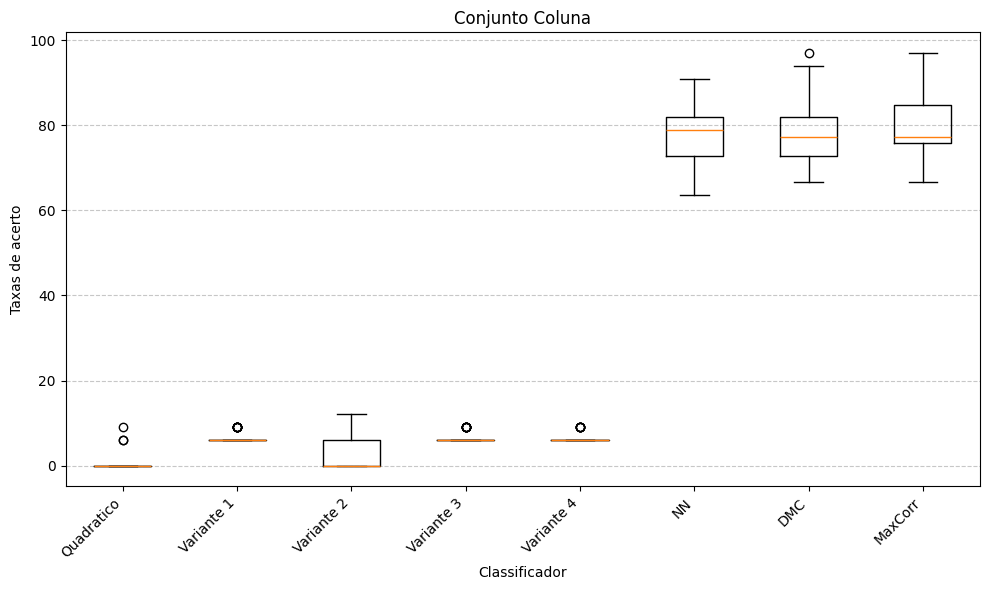

In [123]:
# Boxplot
data_to_plot = [TX_OK0, TX_OK1, TX_OK2, TX_OK3, TX_OK4, TX_OK5, TX_OK6, TX_OK7]
labels = ["Quadratico", "Variante 1", "Variante 2", "Variante 3", "Variante 4","NN", "DMC", "MaxCorr" ]

plt.figure(figsize=(10, 6))
plt.boxplot(data_to_plot)
plt.xticks(range(1, len(labels) + 1), labels, rotation=45, ha='right')
plt.title('Conjunto Coluna')
plt.xlabel('Classificador')
plt.ylabel('Taxas de acerto')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Aplicação do PCA para solucionar as atividades 3 e 4

In [125]:

q = 400  # Garante que q não exceda o limite permitido
pca = PCA(q)
X_reduced = pca.fit_transform(X.T).T # Aplica PCA nas imagens (linhas de X.T) e transpõe de volta

# Variância explicada acumulada
VEq = np.cumsum(pca.explained_variance_ratio_)
plt.figure()
plt.plot(range(1, len(VEq) + 1), VEq, 'r-', linewidth=3)
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Variância Explicada Acumulada')
plt.title('Variância Explicada Acumulada por PCA')
plt.grid(True)
plt.show()

X = X_reduced # X agora é o X transformado pelo PCA

Z = np.vstack((X, Y))  # Formato 01 vetor de atributos por coluna: DIM(Z) = (p+1)xN
Z = Z.T     # Formato 01 vetor de atributos por linha: DIM(Z) = Nx(p+1)

ValueError: n_components=400 must be between 0 and min(n_samples, n_features)=165 with svd_solver='full'

# Carregamento dos dados e execução dos classificadores com PCA 

In [ ]:
#Carrega os dados
try:
    D = np.loadtxt('recfaces.dat')
except FileNotFoundError:
    print("Erro: 'recfaces.dat' não encontrado. Por favor, execute 'face_preprocessing_column.py' primeiro.")
    exit()

Nr = 50  # No. de repeticoes
Ptrain = 80  # Porcentagem de treinamento

# Executa os classificadores
start_time = time.time()
STATS_0, TX_OK0, X0, m0, S0, posto0 = quadratico(D, Nr, Ptrain)
Tempo0 = time.time() - start_time

start_time = time.time()
STATS_1, TX_OK1, X1, m1, S1, posto1 = variante1(D, Nr, Ptrain, 0.01)
Tempo1 = time.time() - start_time

start_time = time.time()
STATS_2, TX_OK2, X2, m2, S2, posto2 = variante2(D, Nr, Ptrain)
Tempo2 = time.time() - start_time

start_time = time.time()
STATS_3, TX_OK3, X3, m3, S3, posto3 = variante3(D, Nr, Ptrain, 0.5)
Tempo3 = time.time() - start_time

start_time = time.time()
STATS_4, TX_OK4, X4, m4, S4, posto4 = variante4(D, Nr, Ptrain)
Tempo4 = time.time() - start_time

start_time = time.time()
STATS_5, TX_OK5, X5, m5, S5, posto5 = NN(D, Nr, Ptrain)
Tempo5 = time.time() - start_time

start_time = time.time()
STATS_6, TX_OK6, X6, m6, S6, posto6 = MDC(D, Nr, Ptrain)
Tempo6 = time.time() - start_time

start_time = time.time()
STATS_7, TX_OK7, X7, m7, S7, posto7 = MaxCorr(D, Nr, Ptrain)
Tempo7 = time.time() - start_time


/tmp/ipykernel_4507/515847498.py:82: UserWarning: Determinante para classe 1.0 não-positivo. Tratando log como -inf.
  warnings.warn(f"Determinante para classe {c} não-positivo. Tratando log como -inf.")
/tmp/ipykernel_4507/515847498.py:82: UserWarning: Determinante para classe 4.0 não-positivo. Tratando log como -inf.
  warnings.warn(f"Determinante para classe {c} não-positivo. Tratando log como -inf.")
/tmp/ipykernel_4507/515847498.py:82: UserWarning: Determinante para classe 6.0 não-positivo. Tratando log como -inf.
  warnings.warn(f"Determinante para classe {c} não-positivo. Tratando log como -inf.")
/tmp/ipykernel_4507/515847498.py:82: UserWarning: Determinante para classe 10.0 não-positivo. Tratando log como -inf.
  warnings.warn(f"Determinante para classe {c} não-positivo. Tratando log como -inf.")
/tmp/ipykernel_4507/515847498.py:82: UserWarning: Determinante para classe 11.0 não-positivo. Tratando log como -inf.
  warnings.warn(f"Determinante para classe {c} não-positivo. Trat

In [ ]:
# Constrói um DataFrame consolidado
tabela_resultados = pd.DataFrame()

# Preenche com os dados de estatísticas e tempo
for classificador, stats, tempo in [
    ("Quadrático", STATS_0, Tempo0),
    ("Variante 1", STATS_1, Tempo1),
    ("Variante 2", STATS_2, Tempo2),
    ("Variante 3", STATS_3, Tempo3),
    ("Variante 4", STATS_4, Tempo4),
    ("1-NN", STATS_5, Tempo5),
    ("DMC", STATS_6, Tempo6),
    ("MaxCorr", STATS_7, Tempo7)
]:
    # Cria uma série com os resultados do classificador atual
    resultados_classificador = pd.Series(stats)
    resultados_classificador['Tempo de execução'] = tempo
    tabela_resultados[classificador] = resultados_classificador

# Transpõe o DataFrame para ter os classificadores como linhas
tabela_resultados = tabela_resultados.T

print("\nTabela de Resultados com PCA")
print(tabela_resultados.to_string(float_format='%.4f'))


Tabela de Resultados com PCA
             Média  Mínimo   Máximo  Mediana  Desvio Padrão  Tempo de execução
Quadrático  6.5455  6.0606   9.0909   6.0606         1.1222             0.3903
Variante 1 77.6364 66.6667  93.9394  75.7576         6.7313             0.3687
Variante 2 95.7576 87.8788 100.0000  96.9697         3.6219             0.2523
Variante 3 92.8485 78.7879 100.0000  93.9394         5.0395             0.3492
Variante 4 77.6364 60.6061  90.9091  78.7879         6.8417             0.3374
1-NN       77.3333 63.6364  90.9091  78.7879         6.3103             0.0654
DMC        77.0303 63.6364  96.9697  75.7576         6.8472             0.1210
MaxCorr    77.0909 63.6364  96.9697  77.2727         6.8491             0.0813
